In [79]:
# 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''알고리즘 관련 라이브러리'''
import lightgbm as lgb

'''텐서플로 및 케라스 관련 라이브러리'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy


In [80]:
'''
무비렌즈 데이터 셋
20,000,263 평점
27,278 영화
138,493 사용자
'''
path = 'C:\\Users\\kt NexR\\PycharmProjects\\Recommendation-algorithms\\Deep Learning_recommendation\\data\\movie-lens'
ratingDF = pd.read_csv(path + '\\ratings.csv', encoding='utf-8')
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [81]:
ratingDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


In [82]:
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = ratingDF.timestamp.apply(lambda x: \
                    datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [83]:
ratingDF.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [84]:
# 향후 더 빠른 로딩을 위해 데이터 프레임을 피클로 저장
current_path = "C:\\Users\\kt NexR\\PycharmProjects\\Recommendation-algorithms\\Deep Learning_recommendation"
pickle_file = os.path.sep.join(['','datasets'])
file_path = current_path+pickle_file
if not os.path.exists(file_path):
    os.mkdir(file_path)
ratingDF.to_pickle(file_path+'ratingPickle.pkl')

In [85]:
#다시 받아오기 pickle
data = pd.read_pickle(file_path+'ratingPickle.pkl')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int32  
 1   movieId    int32  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int32(2), object(1)
memory usage: 457.8+ MB


In [107]:
n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  138493
Number of unique movies:  26744
Number of total ratings:  20000263
Average number of ratings per user:  144.4135299257002


In [117]:
# 상위 1000개 영화 추출로 데이터 셋 크기 축소
movieIndex = ratingDF.groupby('movieId').count().sort_values(by='rating', ascending = False)[0:1000].index
ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

In [118]:
# 사용자 1000명 샘플링으로 데이터 셋 크기 축소
userIndex = ratingDFX2.groupby('userId').count().sort_values(by='rating', ascending=False).sample(n=1000, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

In [119]:
# 영화 ID 다시 인덱싱
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1
moviesDF.head()

,originalMovieId,newMovieId
0,50,1
1,163,2
2,216,3
3,296,4
4,333,5


In [120]:
# 사용자 ID 다시 인덱싱
users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users, columns=['originalUserId'])
moviesDF['newUserId'] = moviesDF.index+1

In [121]:
ratingDFX3.head()

,userId,movieId,rating,timestamp
4943,49,50,5.0,2013-05-03 02:50:26
4944,49,163,3.5,2013-05-03 02:43:37
4945,49,216,3.0,2013-05-03 02:45:58
4946,49,296,5.0,2013-05-03 02:50:13
4947,49,333,3.0,2013-05-03 02:44:38


In [122]:
# 새롭게 병합된 데이터프레임 생성
ratingDFX3 = ratingDFX3.merge(moviesDF,left_on='movieId', \
                              right_on='originalMovieId')
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)
ratingDFX3 = ratingDFX3.merge(usersDF,left_on='userId', \
                              right_on='originalUserId')
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)
ratingDFX3.head()

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,49,50,5.0,2013-05-03 02:50:26,1,1
1,49,163,3.5,2013-05-03 02:43:37,2,2
2,49,216,3.0,2013-05-03 02:45:58,3,3
3,49,296,5.0,2013-05-03 02:50:13,4,4
4,49,333,3.0,2013-05-03 02:44:38,5,5


In [123]:
pickle_file = os.path.sep.join(['', 'datasets', 'ratingReducedPickle'])
ratingDFX3.to_pickle(current_path + pickle_file)
ratingDFX3 = pd.read_pickle(current_path + pickle_file)

In [124]:
ratingDFX3.count()

userId        90213
movieId       90213
rating        90213
timestamp     90213
newMovieId    90213
newUserId     90213
dtype: int64

In [125]:
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

print("Number of unique users: ", n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  90213
Average number of ratings per user:  90.213


In [126]:
X_train, X_test = train_test_split(ratingDFX3, test_size=0.10, shuffle=True, random_state=2018)
X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=2018)

In [127]:
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]


sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print('Sparsity : {:4.2f}%'.format(sparsity))

Sparsity : 0.10%


In [135]:
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] =row[3]

In [151]:
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()
actual_validation.shape

(942,)

In [156]:
pred_validation = np.zeros((len(actual_validation),1))
pred_validation[pred_validation==0]=3.5
pred_validation= pred_validation.flatten()
pred_validation.shape

(942,)

In [157]:
mean_squared_error(pred_validation, actual_validation)

1.0459129511677283

### MF 사용

In [158]:
## 실험1 - 하나의 잠재요인 가진 행렬 인수분해를 사용한 추천 시스템
n_latent_factors = 1

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors,
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [159]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=100, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 2s 532us/step - loss: 13.7002 - val_loss: 10.4096

Minimum MSE:  0.9133200645446777


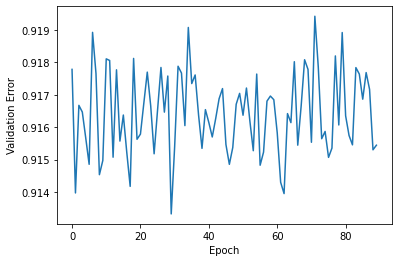

In [160]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [161]:
# 실험2 - 세개의 잠재요인 가진 행렬 인수분해를 사용한 추천 시스템
n_latent_factors = 3

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           embeddings_regularizer=regularizers.l1(10e-7), \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors, \
                            embeddings_regularizer=regularizers.l1(10e-7), \
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [162]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=100, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 2s 675us/step - loss: 12.9353 - val_loss: 6.2061

Minimum MSE:  0.9219405651092529


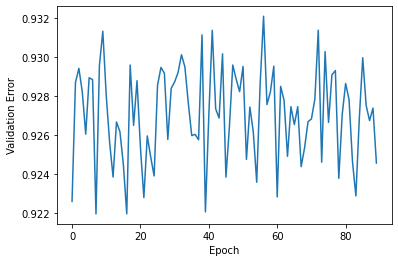

In [163]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [164]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 3)         3003        movie[0][0]                      
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 3)         3003        user[0][0]                       
____________________________________________________________________________________________

### RBM 사용

In [212]:
#tf2 버전으로 코드 수정 필요
import tensorflow.compat.v1 as tf1

class RBM(object):

    def __init__(self, input_size, output_size,
                 learning_rate, epochs, batchsize):
        # 하이퍼파라미터 정의
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize

        # 0행렬 사용한 가중치 및 편향 초기화
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.Variable(tf.ones(shape=[self._input_size, self._output_size]))
        _hb = tf.Variable(tf.ones(shape=[self._output_size]))
        _vb = tf.Variable(tf.ones(shape=[self._input_size]))

        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)

        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)

        v0 = tf.Variable(tf.zeros(shape=(None, self._input_size)), dytype=tf.float32)
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        err = tf.reduce_mean(tf.square(v0 - v1))

        error_list = []

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):

        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

In [213]:
# 훈련 사이클 시작

# inputX를 float32로 데이터 유형 변환
inputX = ratings_train
inputX = inputX.astype(np.float32)

# 훈련을 위한 RBMs 파라미터 정의
rbm=RBM(1000,1000,1,1000,200)

In [214]:
# RBM 모델 훈련
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [194]:
# 재구성 오차 그래프
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

NameError: name 'err' is not defined

In [180]:
# 검증 셋을 위한 평점 예측
inputValidation = ratings_validation
inputValidation = inputValidation.astype(np.float32)

finalOutput_validation, reconstructedOutput_validation, _ = \
    rbm.rbm_output(inputValidation)

AttributeError: module 'tensorflow' has no attribute 'random_uniform'

In [181]:
# 검증 셋을 위한 MSE 계산
predictionsArray = reconstructedOutput_validation
pred_validation = \
    predictionsArray[ratings_validation.nonzero()].flatten()
actual_validation = \
    ratings_validation[ratings_validation.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using RBM prediction:', rbm_prediction)

NameError: name 'reconstructedOutput_validation' is not defined